In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
# dec. sobre a função: @jit(nopython=True)

Iterations: 199


Text(0, 0.5, 'Potential (V)')

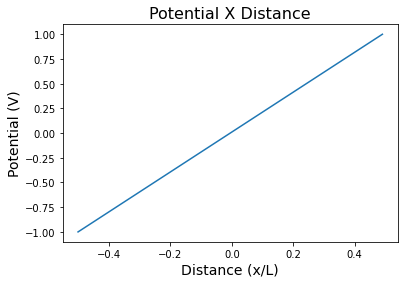

In [2]:
## Unidimensional Region Between Plates ##

n = 100
initialGuess = np.zeros(n)
initialGuess[-1], initialGuess[0] = 1, -1
domain = np.arange(n)/n - 0.5
w = 1.941

def sorMethod1D(potential, convergenceCriteria, w):
    n = potential.shape[0]
    iterations = 0
    residue = 1
    wBest, nIterations = 0, 10000
    
    while residue > convergenceCriteria:
        iterations += 1
        formerPotential = np.copy(potential)
        for j in range(1, n-1):
            potential[j] = (1-w)*potential[j] + w*(potential[j-1] + potential[j+1])/2
        residue = np.linalg.norm(potential - formerPotential)
        if iterations >= 20000:
            print(f'Exceeded maximum iterations allowed (w = {w})')
            print(f'Current residue: {residue}')
            break        
    return (potential, iterations)

potentialBetweenPlates, iterations = sorMethod1D(initialGuess, 1e-4, w)


print(f'Iterations: {iterations}')
plt.plot(domain , potentialBetweenPlates)
plt.title("Potential X Distance", fontsize=16)
plt.xlabel("Distance (x/L)", fontsize=14)
plt.ylabel("Potential (V)", fontsize=14)

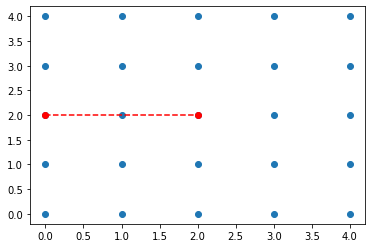

In [3]:
## Bidimensional Case: First Quadrant ##

## Parameters ##
V0 = 1
lx = 2
d = 2
Dx, Dy = 2, 2
h = 0.5
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))

    
## Visualizing the Grid (1st quadrant) ##
x, y = np.meshgrid(np.linspace(0, Nx, Nx+1), np.linspace(0, Ny, Ny+1))

plt.scatter(x, y)

xCapacitor = np.array([0, Nl])
yCapacitor = np.array([Nh, Nh])

plt.plot(xCapacitor, yCapacitor, 'ro', linestyle='--')

Iterations: 9
0.239


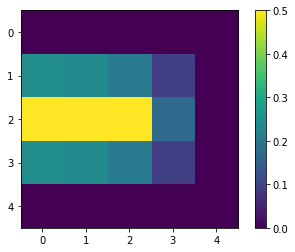

In [4]:
## Setting Initial Guess ##
initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for i in range(Nl+1):
    initialGuess[i][-Nh-1] = 0.5*V0
potential = np.copy(initialGuess)

## SOR Method for Test Case (1st quadrant) ##
residue = 1
convergenceCriteria = 1e-4
iterations = 0
w = 1

while residue > convergenceCriteria:
    iterations += 1
    formerPotential = np.copy(potential)
    for i in range(Nx):
        for j in range(1, Ny):
            if j == Ny-Nh and i <= Nl:
                continue
            if i==0:
                potential[i][j] = (1-w)*potential[i][j] + w*(potential[i][j-1] + potential[i][j+1] + potential[i+1][j] + potential[i][j])/4
                continue
            potential[i][j] = (1-w)*potential[i][j] + w*(potential[i][j-1] + potential[i][j+1] + potential[i+1][j] + potential[i-1][j])/4
    residue = np.linalg.norm(potential - formerPotential)
    if iterations >= 20000:
        print(f'Exceeded maximum iterations allowed (w = {w})')
        print(f'Current residue: {residue}')
        break

print(f'Iterations: {iterations}')
fig, ax = plt.subplots(1, 1)
im = ax.imshow(np.transpose(potential))
fig.colorbar(im)
print(f'{potential[1][3]:.3}')

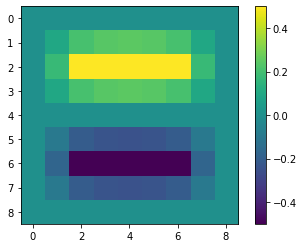

In [5]:
## Potential on XY Plane ##
quarterPotential = np.transpose(potential)
totalPotential = np.resize(np.zeros(1), (2*(Nx+1)-1, 2*(Ny+1)-1))
for i in range(Nx+1):
    for j in range(Ny+1):
        totalPotential[i][Ny+j] = quarterPotential[i][j]
        totalPotential[i][j] = quarterPotential[i][-j-1]
        totalPotential[-i-1][j] = -totalPotential[i][j]
        totalPotential[-i-1][-j-1] = totalPotential[-i-1][j]
fig, ax = plt.subplots(1, 1)
im = ax.imshow(totalPotential)
fig.colorbar(im)